In [1]:
import tables as tb
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cmocean

## The HDF5 event files
The dataframes (called 'Particles') are stored in HDF5 files. There is one file for simulated 2vbb events, and one file for simulated background events. The backrounds simulated are Tl208, Bi214, Co60, and K40.

For the backgrounds, there is one entry per event, and for 2vbb, there are two entries per event (one for each primary electron). All of the 2vbb events can be keyed by the 'event' attribute, which is unique.

In [3]:
file = './files/Xe2nu_NEW_v1.2.0_cdst.0_0.h5'
tin = tb.open_file(file, 'r')

In [4]:
evt_list = tin.root.CHITS.highTh[:]['event']
evt_trk_list = tin.root.Tracking.Tracks[:]['event']
evt_dst_list = tin.root.DST.Events[:]['event']
evt_ext_list = tin.root.MC.extents[:]['evt_number']

Passed nS2 == 1

Passed fiducial cut
X pos: min = 25.0, max = 55.0
Y pos: min = -55.0, max = -15.0
Z pos: min = 32.53621875, max = 59.784062500000005

Passed single track cut

Failed blob overlap cut
Overlap energy: 0.05113204884863566 MeV

Passed blob 2 energy cut
Blob 2 energy: 0.38167505598543033 MeV

Electron variables:
Opening angle: 0.6367354066636769 rad
Electron 1 multiple scattering angle: 2.3564678423404186 rad
Electron 2 multiple scattering angle: 2.2577635047944087 rad


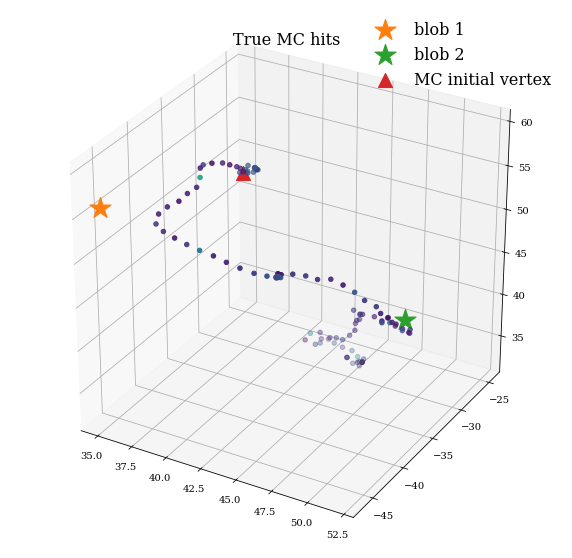

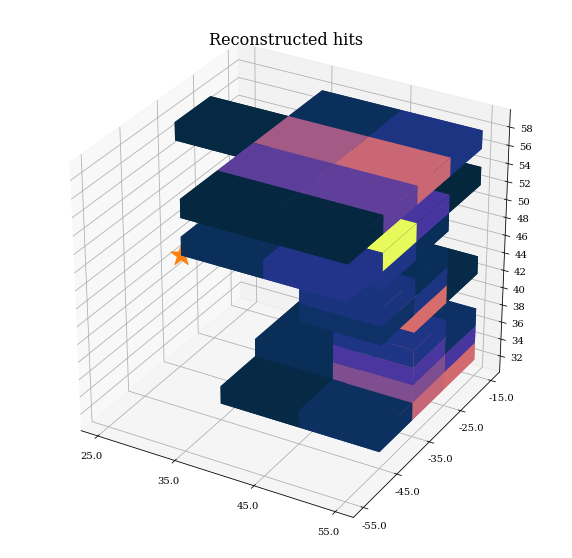

In [10]:
'''
Event number: (change this to look at different events)
'''
evt = 0

# get hit indices associated with this event
evt_idx = evt_list == evt
evt_trk_idx = evt_trk_list == evt
evt_dst_idx = evt_dst_list == evt
evt_ext_idx = np.where(evt_ext_list == evt)[0][0]

if evt_ext_idx != 0:
    mc_hit_min = int(tin.root.MC.extents[evt_ext_idx - 1]['last_hit'] + 1)
    mc_particle_min = int(tin.root.MC.extents[evt_ext_idx - 1]['last_particle'] + 1)
else:
    mc_hit_min = 0
    mc_particle_min = 0
mc_hit_max = int(tin.root.MC.extents[evt_ext_idx]['last_hit'] + 1)
mc_particle_max = int(tin.root.MC.extents[evt_ext_idx]['last_particle'] + 1)

# get primary electrons
evt_parts = tin.root.MC.particles[mc_particle_min:mc_particle_max]

# plot true MC hits
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tin.root.MC.hits[mc_hit_min:mc_hit_max]['hit_position'].T[0], tin.root.MC.hits[mc_hit_min:mc_hit_max]['hit_position'].T[1], tin.root.MC.hits[mc_hit_min:mc_hit_max]['hit_position'].T[2], c=tin.root.MC.hits[mc_hit_min:mc_hit_max]['hit_energy'])
ax.scatter(tin.root.Tracking.Tracks[evt_trk_idx]['blob1_x'], tin.root.Tracking.Tracks[evt_trk_idx]['blob1_y'], tin.root.Tracking.Tracks[evt_trk_idx]['blob1_z'], c='C1', s=500, marker='*', label='blob 1')
ax.scatter(tin.root.Tracking.Tracks[evt_trk_idx]['blob2_x'], tin.root.Tracking.Tracks[evt_trk_idx]['blob2_y'], tin.root.Tracking.Tracks[evt_trk_idx]['blob2_z'], c='C2', s=500, marker='*', label='blob 2')
ax.scatter(evt_parts['initial_vertex'][0][0], evt_parts['initial_vertex'][0][1], evt_parts['initial_vertex'][0][2], c='C3', s=200, marker='^', label='MC initial vertex')

plt.title('True MC hits', fontsize=16)
plt.legend(fontsize=16)


# voxelize reconstructed hits
x = tin.root.CHITS.highTh[evt_idx]['X']
y = tin.root.CHITS.highTh[evt_idx]['Y']
z = tin.root.CHITS.highTh[evt_idx]['Z']
e = tin.root.CHITS.highTh[evt_idx]['Ec']

xbins = np.arange(x.min() - (x.min()%5), x.max() + (5-(x.max()%5)), 10)
ybins = np.arange(y.min() - (y.min()%5), y.max() + (5-(y.max()%5)), 10)
zbins = np.arange(z.min() - (z.min()%2), z.max() + (2-(z.max()%2)), 2)
vox,evtbins = np.histogramdd((x,y,z), weights=e, bins=(xbins,ybins,zbins))

b1x = int((tin.root.Tracking.Tracks[evt_trk_idx]['blob1_x'] - x.min()) / (x.max() + (5-(x.max()%5)) - (x.min() - (x.min()%5))) * len(xbins))
b1y = int((tin.root.Tracking.Tracks[evt_trk_idx]['blob1_y'] - y.min()) / (y.max() + (5-(y.max()%5)) - (y.min() - (y.min()%5))) * len(ybins))
b1z = int((tin.root.Tracking.Tracks[evt_trk_idx]['blob1_z'] - z.min()) / (z.max() + (5-(z.max()%5)) - (z.min() - (z.min()%5))) * len(zbins))
b2x = int((tin.root.Tracking.Tracks[evt_trk_idx]['blob2_x'] - x.min()) / (x.max() + (5-(x.max()%5)) - (x.min() - (x.min()%5))) * len(xbins))
b2y = int((tin.root.Tracking.Tracks[evt_trk_idx]['blob2_y'] - y.min()) / (y.max() + (5-(y.max()%5)) - (y.min() - (y.min()%5))) * len(ybins))
b2z = int((tin.root.Tracking.Tracks[evt_trk_idx]['blob2_z'] - z.min()) / (z.max() + (5-(z.max()%5)) - (z.min() - (z.min()%5))) * len(zbins))

evtvox = np.zeros(vox.shape)
evtvox[vox.nonzero()] = 1

colors = cmocean.cm.thermal
colvox = colors(vox/vox.max())

# plot reconstructed hits
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.voxels(evtvox,facecolors=colvox);#, edgecolor="k");
ax.scatter(b1x,b1y,b1z, c='C1', s=500, marker='*')
ax.scatter(b2x,b2y,b2z, c='C2', s=500, marker='*')

# relabel to original coordinates
xlabs = [str(i) for i in np.arange(0,len(evtbins[0]),1)*10 + x.min()]
ylabs = [str(i) for i in np.arange(0,len(evtbins[1]),1)*10 + y.min()]
zlabs = [str(i) for i in np.arange(0,len(evtbins[2]),1)*2 + int(z.min())]
ax.set_xticks(np.arange(0,len(evtbins[0]),1))
ax.set_yticks(np.arange(0,len(evtbins[1]),1))
ax.set_zticks(np.arange(0,len(evtbins[2]),1))
ax.set_xticklabels(xlabs)
ax.set_yticklabels(ylabs)
ax.set_zticklabels(zlabs)

plt.title('Reconstructed hits', fontsize=16)

'''
print event information:
'''
# nS2 cut
if tin.root.DST.Events[evt_dst_idx]['nS2'] == 1:
    print('Passed nS2 == 1')
else:
    print('Failed nS2 == 1')
    print('nS2 == %s'%tin.root.DST.Events[evt_dst_idx]['nS2'])
print()
    
# fiducial cut
r = np.sqrt(x**2 + y**2)
if len(np.where((z <= 20)|(z >= 510))[0]) > 0 or len(np.where(r >= 178)[0]) > 0:
    print('Failed fiducial cut')
else:
    print('Passed fiducial cut')
print('X pos: min = %s, max = %s'%(x.min(), x.max()))
print('Y pos: min = %s, max = %s'%(y.min(), y.max()))
print('Z pos: min = %s, max = %s'%(z.min(), z.max()))
print()
    
# single track cut
if tin.root.Tracking.Tracks[evt_trk_idx]['numb_of_tracks'][0] == 1:
    print('Passed single track cut')
else:
    print('Failed single track cut')
    print('Number of tracks: %s'%tin.root.Tracking.Tracks[evt_trk_idx]['numb_of_tracks'][0])
print()

# blob overlap cut
if tin.root.Tracking.Tracks[evt_trk_idx]['ovlp_blob_energy'][0] == 0:
    print('Passed blob overlap cut')
else:
    print('Failed blob overlap cut')
    print('Overlap energy: %s MeV'%tin.root.Tracking.Tracks[evt_trk_idx]['ovlp_blob_energy'][0])
print()

# blob energy cut
eblob2 = tin.root.Tracking.Tracks[evt_trk_idx]['eblob2'][0]
ereco = tin.root.Tracking.Tracks[evt_trk_idx]['energy'][0]
if eblob2*1000 > 355.55*(1-np.exp(-0.001333*ereco*1000)):
    print('Passed blob 2 energy cut')
else:
    print('Failed blob 2 energy cut')
print('Blob 2 energy: %s MeV'%eblob2)
print()


print('Electron variables:')
# calculate opening angle
moms = evt_parts[evt_parts['primary'] == 1]['momentum']
theta = np.arccos(sum(moms[0]*moms[1])/(np.linalg.norm(moms[0])*np.linalg.norm(moms[1])))
print('Opening angle: %s rad'%theta)

# calculate multiple scattering angle
displacement = evt_parts[evt_parts['primary'] == 1]['final_vertex'] - evt_parts[evt_parts['primary'] == 1]['initial_vertex']
initial_pos = evt_parts[evt_parts['primary'] == 1]['initial_vertex']
mcs1 = np.arccos(sum(displacement[0][:3]*moms[0])/(np.linalg.norm(displacement[0][:3])*np.linalg.norm(moms[0])))
mcs2 = np.arccos(sum(displacement[1][:3]*moms[1])/(np.linalg.norm(displacement[1][:3])*np.linalg.norm(moms[1])))
print('Electron 1 multiple scattering angle: %s rad'%mcs1)
print('Electron 2 multiple scattering angle: %s rad'%mcs2)